<a href="https://colab.research.google.com/github/duonghung86/Vehicle-trajectory-tracking/blob/master/Codes/VTP_1_10_Models_for_full_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing models for full dataset
---

## Import packages

In [3]:
# General
import numpy as np
import time
import os

# Loading datasets
from io import StringIO, BytesIO
from zipfile import ZipFile
import urllib.request

# For data processing
import pandas as pd
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

# For prediction model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

## Load dataset

In [4]:
def url2pd(link):
    with ZipFile(link) as my_zip_file:
        for contained_file in my_zip_file.namelist():
            fzip=my_zip_file.open(contained_file)
            data=fzip.read()
    s=str(data,'utf-8')
    data = StringIO(s) 
    print('Done loading a dataset!')
    return pd.read_csv(data)

In [5]:
filenames = os.listdir('./Data')
filenames

['0750_0805_us101_smoothed_11_.zip',
 '0805_0820_us101_smoothed_11_.zip',
 '0820_0835_us101_smoothed_11_.zip',
 'trajectories-0400-0415.zip',
 'trajectories-0500-0515.zip',
 'trajectories-0515-0530.zip']

In [21]:
# Set constant values
HISTORY_LENGTH = 3
FUTURE_LENGTH = 5
TIME_STEP = 0.2
n_steps = int(HISTORY_LENGTH/0.2)
n_future = int(FUTURE_LENGTH/0.2)
#n_features = len(df)

target_names = ['Local_X','v_Vel']

In [22]:
def single_series2seq(pdseries,n_in=3, n_out=10,step_in=1, step_out=5):
    seq = pdseries.copy()
    agg = pd.DataFrame()
    for i in range(n_in, 0, -step_in):
        name = '{}(-{:.1f}s)'.format(seq.name, (i-1)*TIME_STEP)
        agg[name] = seq.shift(i)
    input_len = agg.shape[1]
    for i in range(0, n_out,1):
        name = '{0}({1:.2f}s)'.format(seq.name, (i+1)*TIME_STEP)
        agg[name] = seq.shift(-i)
    # put it all together
    agg.dropna(inplace=True)
    agg.reset_index(drop=True,inplace=True)
    
    X = agg.iloc[:,:input_len].copy()
    Y = agg.iloc[:,input_len:].copy()
    Y = Y.iloc[:,step_out-1::step_out]
    return X,Y
test_series = pd.Series(np.arange(20),name='test')
single_series2seq(test_series)

(   test(-0.4s)  test(-0.2s)  test(-0.0s)
 0          0.0          1.0          2.0
 1          1.0          2.0          3.0
 2          2.0          3.0          4.0
 3          3.0          4.0          5.0
 4          4.0          5.0          6.0
 5          5.0          6.0          7.0
 6          6.0          7.0          8.0
 7          7.0          8.0          9.0,
    test(1.00s)  test(2.00s)
 0          7.0         12.0
 1          8.0         13.0
 2          9.0         14.0
 3         10.0         15.0
 4         11.0         16.0
 5         12.0         17.0
 6         13.0         18.0
 7         14.0         19.0)

In [23]:
def multiseries2seq(data, **kwarg):
    dat = data.copy()
    n_series = dat.shape[1]
    X, Y = pd.DataFrame(), pd.DataFrame()
    for feat in dat.columns:
        newX, newY = single_series2seq(dat[feat],
                                       n_in = kwarg['n_in'],
                                       step_in = kwarg['step_in'],
                                       n_out = kwarg['n_out'],
                                       step_out = kwarg['step_out'])
        X = pd.concat((X,newX),axis = 1)
        Y = pd.concat((Y,newY),axis = 1)
    return X,Y

test_df = pd.DataFrame(np.arange(20).reshape(-1,2),columns=['a','b'])
multiseries2seq(test_df,n_in=3, n_out=4,step_in=1, step_out=1)

(   a(-0.4s)  a(-0.2s)  a(-0.0s)  b(-0.4s)  b(-0.2s)  b(-0.0s)
 0       0.0       2.0       4.0       1.0       3.0       5.0
 1       2.0       4.0       6.0       3.0       5.0       7.0
 2       4.0       6.0       8.0       5.0       7.0       9.0
 3       6.0       8.0      10.0       7.0       9.0      11.0,
    a(0.20s)  a(0.40s)  a(0.60s)  a(0.80s)  b(0.20s)  b(0.40s)  b(0.60s)  \
 0         6       8.0      10.0      12.0         7       9.0      11.0   
 1         8      10.0      12.0      14.0         9      11.0      13.0   
 2        10      12.0      14.0      16.0        11      13.0      15.0   
 3        12      14.0      16.0      18.0        13      15.0      17.0   
 
    b(0.80s)  
 0      13.0  
 1      15.0  
 2      17.0  
 3      19.0  )

In [24]:
%%time
def treatment_cars(data,labels=None,**kwarg):
    veh_ids = data.Vehicle_ID.unique()
    dat_X, dat_y = pd.DataFrame(),pd.DataFrame()

    for id in veh_ids:
        dat = data[data.Vehicle_ID==id].copy()
        X, Y = multiseries2seq(dat[labels],
                               n_in = kwarg['n_in'],
                               step_in = kwarg['step_in'],
                               n_out = kwarg['n_out'],
                               step_out = kwarg['step_out']) 
        dat_X = pd.concat([dat_X,X],ignore_index=True)
        dat_y = pd.concat([dat_y,Y],ignore_index=True)
    print(dat_X.shape, dat_y.shape)
    return dat_X ,dat_y

Wall time: 0 ns


In [33]:
%%time
X, Y = pd.DataFrame(), pd.DataFrame()
for file in filenames:
    print(file)
    start = time.time()
    url = './Data/' + file
    df = url2pd(url)
    # Filter time step
    print(df.shape)
    df = df.iloc[::2,:].copy()
    df.reset_index(drop=True, inplace=True)
    print('After filtering:', df.shape)
    #  keep only columns that are useful for now
    kept_cols = ['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Local_X','Local_Y','v_Length', 'v_Width', 'v_Class',
           'v_Vel', 'v_Acc', 'Lane_ID']
    df = df[kept_cols].copy()
    print('The number of vehicles is {}'.format(len(df.Vehicle_ID.unique())))
    print('Converting to sequences ...')
    newX, newY = treatment_cars(df,n_in=n_steps, n_out=n_future,step_in=1, step_out=5, labels = target_names)
    X = pd.concat((X,newX),ignore_index=True)
    Y = pd.concat((Y,newY),ignore_index=True)
    end = time.time()
    print(X.shape,Y.shape)
    print('Preparing time is {0:.2f}s'.format(end-start))

0750_0805_us101_smoothed_11_.zip
Done loading a dataset!
(1048575, 18)
After filtering: (524288, 18)
The number of vehicles is 1993
Converting to sequences ...
(446561, 30) (446561, 10)
(446561, 30) (446561, 10)
Preparing time is 105.07s
0805_0820_us101_smoothed_11_.zip
Done loading a dataset!
(1048575, 18)
After filtering: (524288, 18)
The number of vehicles is 1533
Converting to sequences ...
(464501, 30) (464501, 10)
(911062, 30) (911062, 10)
Preparing time is 85.32s
0820_0835_us101_smoothed_11_.zip
Done loading a dataset!
(1048575, 18)
After filtering: (524288, 18)
The number of vehicles is 1298
Converting to sequences ...
(473671, 30) (473671, 10)
(1384733, 30) (1384733, 10)
Preparing time is 72.65s
trajectories-0400-0415.zip
Done loading a dataset!
(1048575, 18)
After filtering: (524288, 18)
The number of vehicles is 1725
Converting to sequences ...
(457013, 30) (457013, 10)
(1841746, 30) (1841746, 10)
Preparing time is 93.66s
trajectories-0500-0515.zip
Done loading a dataset!
(1

### Split the data set


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(1950662, 30) (835998, 30) (1950662, 10) (835998, 10)


In [35]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(X_train.shape)

(1950662, 30)


### Reshape data sets


In [36]:
X_train = X_train.values
X_test = X_test.values
# reshape into [# samples, # timesteps,# features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))

## Prediction model

In [37]:
%%time
# define model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1],1)))
model.add(Dense(y_test.shape[1]))
model.compile(optimizer='adam', loss='mse')

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=50, batch_size= 1024,
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
1905/1905 [==============================] - 21s 10ms/step - loss: 529.4685 - val_loss: 70.2445
Epoch 2/50
1905/1905 [==============================] - 18s 9ms/step - loss: 48.2007 - val_loss: 21.8342
Epoch 3/50
1905/1905 [==============================] - 18s 9ms/step - loss: 20.1754 - val_loss: 17.6059
Epoch 4/50
1905/1905 [==============================] - 18s 9ms/step - loss: 17.3307 - val_loss: 16.7180
Epoch 5/50
1905/1905 [==============================] - 18s 9ms/step - loss: 16.5970 - val_loss: 16.3324
Epoch 6/50
1905/1905 [==============================] - 18s 9ms/step - loss: 16.3015 - val_loss: 16.2161
Epoch 7/50
1905/1905 [==============================] - 18s 9ms/step - loss: 16.1596 - val_loss: 16.1167
Epoch 8/50
1905/1905 [==============================] - 18s 9ms/step - loss: 16.0743 - val_loss: 15.9372
Epoch 9/50
1905/1905 [==============================] - 18s 9ms/step - loss: 16.0227 - val_loss: 15.9424
Epoch 10/50
1905/1905 [==============================

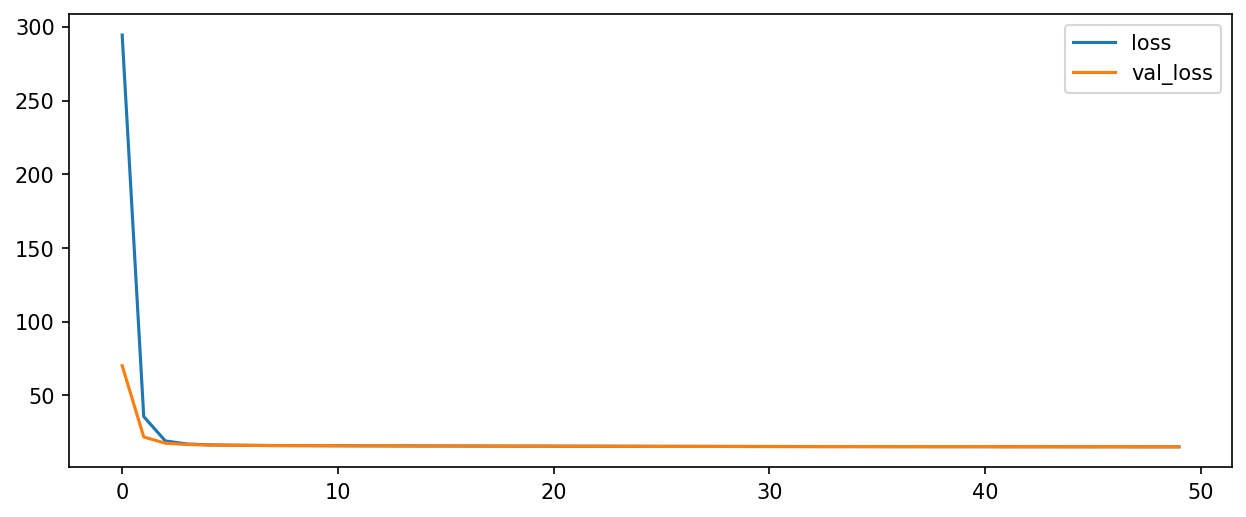

In [38]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes)
#hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()

## Evaluation 


In [39]:
y_hat = model.predict(X_test, verbose=1)
colnames = [str(i)+'s' for i in range(1,6)]
rmse = np.sqrt(np.square(np.subtract(y_test.values,y_hat)).mean(0)).reshape(2,-1)
rmse = pd.DataFrame(rmse,columns = colnames, index = target_names )
rmse.round(3)

26125/26125 [==============================] - 41s 2ms/step


,1s,2s,3s,4s,5s
Local_X,0.581,0.907,1.205,1.474,1.716
v_Vel,3.068,4.180,5.239,6.231,7.113


# END